<a href="https://colab.research.google.com/github/am610/Fisher-Matrix/blob/master/Fisher_SS_Gr_MG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example to add two covariance matrix/Fisher matrix and plot the joint constraint ellipse

In [47]:
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.integrate import quad
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
import math
from matplotlib.patches import Ellipse
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from copy import copy
import seaborn as sns
from google.colab import files

In [48]:
#@title Read File
url = 'https://raw.githubusercontent.com/am610/Fisher-Matrix/master/GW_LCDM_fiducial_MG_2_set_a.txt'
a = pd.read_csv(url,sep=' ')
a.rename(columns = {'GW_LCDM_fiducial_MG_2_set_a.txtz':'z'}, inplace = True)
a = a.sort_values(by=['z'])

In [49]:
a

,z,Dl,sigma,Dl_gw,Dl_gw_a,Dl_gw_b,Dl_gw_c,Dl_gw_2_a,Dl_gw_2_b,Dl_gw_2_c
0,0.123295,0.581216,0.010753,0.576818,0.586620,0.585617,0.589852,0.582107,0.581907,0.582518
1,0.124037,0.591302,0.009342,0.586805,0.596773,0.595756,0.600042,0.592213,0.592009,0.592633
2,0.181253,0.917936,0.037903,0.908557,0.925542,0.924075,0.929963,0.919935,0.919488,0.920860
3,0.182466,0.935397,0.024681,0.925791,0.946052,0.944301,0.952945,0.937445,0.936987,0.938394
4,0.193745,0.927726,0.049095,0.917770,0.938187,0.936452,0.944918,0.929869,0.929390,0.930862
...,...,...,...,...,...,...,...,...,...,...
995,3.737240,54.015611,10.321849,52.428319,54.390174,54.314847,54.600830,54.875698,54.706219,55.328672
996,3.948557,52.722056,10.549856,51.169429,53.231067,53.138144,53.538949,53.578806,53.410648,54.031620
997,4.181535,36.694235,12.194610,35.611421,36.786522,36.766113,36.834217,37.302983,37.183996,37.625912
998,4.282149,41.610018,12.791327,40.381184,42.003125,41.930685,42.239349,42.306151,42.170319,42.676002


In [50]:
#@title Code
# Choose which D_L to scale with
d = a['Dl']*1000 # Mpc

# redshift error
a['sigma_photoz']=0.03*(1. + a['z'])
# weak-lensing error (Eric)
wl_m = 0.1*a['z']/(1. + 0.07*a['z']) # in magnitude
a['sigma_wl'] = d*wl_m*np.log(10.)/5. # in distance
# Sigma Peculiar Velocity arxiv astro-ph/0505394 Eq. (12) or 1601.07112 Eq. (7.4)
v_pec = 500. # km/s
c = 299792458./1000. # km/s
# Hubble constant
H0 = 67.4 #70. # km/s/Mpc
# matter density
O_m = 0.315
# Hubble parameter in flat LCDM model with Omega_Lambda = 1 - Omega_matter
# H(z) in km/s/Mpc
a['H'] = H0*np.sqrt((1. - O_m) + O_m*(1. + a['z'])**3)
f = v_pec/c
X = c*((1. + a['z'])**2)/(d*a['H'])
X = (1. + X)
sig_p = X*f*d
a['sigma_pec'] = sig_p
# Instrument : https://arxiv.org/pdf/1907.01487.pdf eq. 2.17 it is already /Dl
a['sigma_instr'] = 0.1449*a['z']-0.0118*(a['z']**2)+0.0012*(a['z']**3)
a['dl_H']=-d/a.H
a['prefactor'] = -(1+a.z)*H0*c/2. # this is without 'c' Has to be multiplied with c
a.Dl = d # Doing this, so I can use the existing old code, only replacing the Dl with Dl_GW
a.rename({'sigma_photoz': 's_pz', 'sigma_wl': 's_wl', 'sigma_pec' : 's_pec',
          'sigma_instr' : 's_instr'}, axis=1, inplace=True)
a.s_pz = a.s_pz#/a.Dl
a.s_wl = a.s_wl#/a.Dl
a.s_pec = (a.s_pec)#/a.Dl
a.s_instr = a.s_instr#/d
nz = a
c0 = c*(1+a.z)/a.H
c1 = O_m*(1+a.z)**3+(1-O_m)
c3 =(d/(1+a.z) + (c0*(c1**(-0.5))))*a.s_pz
a.s_pz = c3#/a.Dl
#a.s_pz.iloc[:]=0.001 # 50(0.2),85(0.3),100(0.4),125(0.5) 


Om = 0.3  # Omega Matter
Omatter = (1-Om)
w0 = -1
wa = 0

print ('w0, wa used : ', w0, wa)
def X(z):
    a = (1+z)**(-1)
    return Om*(a**-3)+((1-Om)*a**(-3)*(a**(-3*(w0+wa))*np.exp(3*wa*(a-1))))
def dxdm(z,H):
    a = (1+z)**(-1)
    zt = (1+z)
    AA = ((Om*(1+z)**2 + (1 - Om)))**(-0.5)
    HH = (H*np.sqrt(Om/a**3 + (1 - Om)))**2 # H^2 = H_0^2 [Om(1+z)^3 + Om_lambda]
    A = AA/(HH) # eq 44 above
    return A
# 2
def dxdw0(z,H):
    a = (1+z)**(-1)
    zt = (1+z)
    AA = ((Om*(1+z)**2 + (1 - Om)))**(-0.5)
    HH = (H*np.sqrt(Om/a**3 + (1 - Om)))**2 # H^2 = H_0^2 [Om(1+z)^3 + Om_lambda]
    M = -3*np.log(a)*(1 - Om)
    A = AA*M/(HH) # eq 45 above
    return A
# 3
def dxdwa(z,H):
    a = (1+z)**(-1)
    a2 = a-1
    zt = (1+z)
    AA = ((Om*(1+z)**2 + (1 - Om)))**(-0.5)
    HH = (H*np.sqrt(Om/a**3 + (1 - Om)))**2 # H^2 = H_0^2 [Om(1+z)^3 + Om_lambda]
    M  = 3*(1 - Om)*(a-1-np.log(a))
    A = AA*M/HH
    return A

# dxdM = 1 

# PRINTING CHECKS
#print 'Redshift  dx/dm      dx/dwo      dx/dwa'
#print '---------------------------------------'
# for i in (np.linspace(0.05,1.65,17)):
#          print("%.4f    %.4f    %.4f     %.4f " %(i,dxdm(i,0,-1),dxdw0(i,0,-1),dxdwa(i,0,-1)) )
# ************************************************************
# ************************************************************


# Integration Part : STARTS FROmatter BELOW

def H_0D_L(z):  # THIS WILL BE THEN INTEGRATED IN LINE NO. 106
    a = (1+z)**(-1)
    sec = (1-Om)*(a**-3)*(a**(-3*(w0+wa))*np.exp(3*(wa*(a-1))))
    fir = (Om*(a**-3))
    return((fir+sec)**(-0.5))


# ADDITIONAL FUNCTION DECLARATION
def fu1(z,H): 
    return dxdm(z,H) # i = is the row number


def fu2(z,H):
    return dxdw0(z,H)


def fu3(z,H):
    return dxdwa(z,H)

# Z BINS
z = np.array(nz['z'])
H = np.array(nz['H'])
#z = np.linspace(0.15,1.15,12)

# VARIABLE DECLARATION
I_om = []
I_wa = []
I_wo = []
hdl = []
prefactor1 = []
dx_domega = []
dx_dwa = []
dx_dw0 = []

# INTEGRATIONS RUNNING FROM LIMIT [0,Z_BIN[i]]
# THE fu FUNCTION CALLS THE OTHER FUNCTION : DX/DTHETA
# QUAD IS A PYTHON INTEGRATION FUNCTION WITH 3 ARGUMENTS :
# FUNCTION TO INTEGRATE, LOWER LIMIT, UPPER LIMIT

for ii in range(len(z[:])):
    #print(ii)
    I_om.append(quad(fu1, 0, z[ii],args=(nz.H.iloc[ii]))[0])
    I_wo.append(quad(fu2, 0, z[ii],args=(nz.H.iloc[ii]))[0])
    I_wa.append(quad(fu3, 0, z[ii],args=(nz.H.iloc[ii]))[0])
    #hdl.append((1+z[ii])*quad(H_0D_L, 0, z[ii])[0])  # H0_Dl INTEGRATION
    # PREFACTOR WITHOUT THE H0_Dl TERM. THE 1* STANDS FOR 'c'
    #prefactor1.append((-5/np.log(10))*(1*(1+z[ii]))/2)


# STORING THE VALUES IN ARRAYS
for i in range(len(I_om)):
    dx_domega.append((nz.prefactor.iloc[i])*I_om[i])
    dx_dw0.append((nz.prefactor.iloc[i])*I_wo[i])
    dx_dwa.append((nz.prefactor.iloc[i])*I_wa[i])
dx_dH = nz.dl_H
# WRITING TO A FILE
DXDT = pd.DataFrame(zip(z, dx_domega, dx_dw0, dx_dwa, dx_dH))
DXDT.columns = ['z', 'dmdom', 'dmdwo', 'dmdwa', 'dmdH']
#DXDT.to_csv('Fisher_Table_LSST.csv', index=False)

def func():
    return DXDT

np.set_printoptions(precision=4)
# Produced by dmdtheta_ayan_function.py
P = DXDT #pd.read_csv('Fisher_Table_LSST.csv')
#P = pd.read_csv('Fisher_Table_LSST_old.csv')
dmdom = np.array(P['dmdom'])
dmdwo = np.array(P['dmdwo'])
dmdwa = np.array(P['dmdwa'])
dmdM = np.array(P['dmdH']) # I used to assign M = H0 **********
z = np.array(P['z'])
dmdtheta = np.array(list(zip(dmdom, dmdwa, dmdwo, dmdM)))
N_parms = np.shape(dmdtheta)[1]

sigma_sq =(nz.s_pz**2 + nz.s_wl**2 +  nz.s_instr**2 + nz.s_pec**2) #nz.s_pz**2 + nz.s_wl**2 + nz.s_pec**2 + nz.s_instr**2 # sigma's icnrease the error heavily


F = np.zeros([N_parms, N_parms])
# since its scalar product, so order of the terms doesn't matter
dmdM_dmdM = (np.sum(np.multiply(np.multiply(dmdM, dmdM), (1/sigma_sq))))
dmdom_dmdom = (np.sum(np.multiply(np.multiply(dmdom, dmdom), (1/sigma_sq))))
dmdwa_dmdwa = (np.sum(np.multiply(np.multiply(dmdwa, dmdwa), (1/sigma_sq))))
dmdwo_dmdwo = (np.sum(np.multiply(np.multiply(dmdwo, dmdwo), (1/sigma_sq))))
dmdM_dmdom = (np.sum(np.multiply(np.multiply(dmdM, dmdom), (1/sigma_sq))))
dmdM_dmdwo = (np.sum(np.multiply(np.multiply(dmdM, dmdwo), (1/sigma_sq))))
dmdM_dmdwa = (np.sum(np.multiply(np.multiply(dmdM, dmdwa), (1/sigma_sq))))
dmdom_dmdwa = (np.sum(np.multiply(np.multiply(dmdom, dmdwa), (1/sigma_sq))))
dmdom_dmdwo = (np.sum(np.multiply(np.multiply(dmdom, dmdwo), (1/sigma_sq))))
dmdwa_dmdwo = (np.sum(np.multiply(np.multiply(dmdwa, dmdwo), (1/sigma_sq))))

F_I = np.array([dmdM_dmdM,  dmdM_dmdom,  dmdM_dmdwo,  dmdM_dmdwa, 
                dmdM_dmdom, dmdom_dmdom, dmdom_dmdwo, dmdom_dmdwa,
                dmdM_dmdwo, dmdom_dmdwo, dmdwo_dmdwo, dmdwa_dmdwo, 
                dmdM_dmdwa, dmdom_dmdwa, dmdwa_dmdwo, dmdwa_dmdwa])

'''F_I = np.array([dmdom_dmdom, dmdom_dmdwo, dmdom_dmdwa,
                dmdom_dmdwo, dmdwo_dmdwo, dmdwa_dmdwo,
                dmdom_dmdwa, dmdwa_dmdwo, dmdwa_dmdwa ])'''

Fisher_Matrix = F_I.reshape(4, 4)#(4, 4)
Cov_Matrix = np.linalg.pinv(Fisher_Matrix)
C_ij = np.sqrt(np.diag(Cov_Matrix))


# Prior
F_OmOm = 26282.777992634321 #26282.777992634321
F_Omw0 = -7211.5106699248900 #-7211.5106699248900
F_Omwa = -1974.3936330616734 # -1974.3936330616734
F_w0w0 = 1978.7058337978979 # 1/sqrt  1978.7058337978979
F_w0wa = 541.73728345787083 # 541.73728345787083
F_wawa = 148.31880478414203 # 148.31880478414203
F1 = [F_OmOm, F_Omw0, F_Omwa, F_Omw0, F_w0w0, F_w0wa, F_Omwa, F_w0wa, F_wawa]



F1 = np.reshape(F1, (3, 3))
A1 = np.zeros(16)
A1 = np.reshape(A1, (4, 4))
for row in range(1, np.shape(A1)[0]):
    for col in range(1, np.shape(A1)[1]):
        A1[row][col] += F1[row-1][col-1]
F_Ext = A1 # CMB Matrix
#F_Ext = F1


Fisher_Matrix_PRIOR1 = Fisher_Matrix +  F_Ext # Adding Prior, you can add an additional matrix also, like Euclid
print('Fisher Matrix\n',np.array(Fisher_Matrix_PRIOR1))
#Cov_Matrix_PRIOR = np.linalg.pinv(Fisher_Matrix_PRIOR1)
#C_ij_PRIOR = np.sqrt(np.abs(np.diag(Cov_Matrix_PRIOR)))

w0, wa used :  -1 0
Fisher Matrix
 [[ 8.6532e+00  1.1937e+02  6.9695e+01  1.2335e+01]
 [ 1.1937e+02  2.8144e+04 -6.2031e+03 -1.8064e+03]
 [ 6.9695e+01 -6.2031e+03  2.5642e+03  6.4413e+02]
 [ 1.2335e+01 -1.8064e+03  6.4413e+02  1.6688e+02]]


In [51]:
#@title
set(a)

{'Dl',
 'Dl_gw',
 'Dl_gw_2_a',
 'Dl_gw_2_b',
 'Dl_gw_2_c',
 'Dl_gw_a',
 'Dl_gw_b',
 'Dl_gw_c',
 'H',
 'dl_H',
 'prefactor',
 's_instr',
 's_pec',
 's_pz',
 's_wl',
 'sigma',
 'z'}

In [52]:
#@title 
F1 = np.array([[ 8.6532e+00,  1.1937e+02,  6.9695e+01,  1.2335e+01],   # GR,Dl
 [ 1.1937e+02,  2.8144e+04, -6.2031e+03, -1.8064e+03],
 [ 6.9695e+01, -6.2031e+03,  2.5642e+03,  6.4413e+02],
 [ 1.2335e+01, -1.8064e+03,  6.4413e+02,  1.6688e+02]])



F1b = np.array( [[ 8.5336e+00,  1.2024e+02,  7.0354e+01,  1.2474e+01],  # GW, Dl
 [ 1.2024e+02,  2.8194e+04, -6.1724e+03, -1.8008e+03],
 [ 7.0354e+01, -6.1724e+03,  2.5836e+03,  6.4775e+02],
 [ 1.2474e+01, -1.8008e+03,  6.4775e+02,  1.6758e+02]])

In [53]:
F2 = F1 + F1b

In [54]:
#@title 
Cov_1 = np.linalg.pinv(F1)  # GR
C_ij_PRIOR1 = np.sqrt(np.abs(np.diag(Cov_1)))
print(C_ij_PRIOR1)

Cov_2 = np.linalg.pinv(F1b)  # GW
C_ij_PRIOR2 = np.sqrt(np.abs(np.diag(Cov_2)))
print(C_ij_PRIOR2)

Cov_3 = np.linalg.pinv(F2)  # GR + GW
C_ij_PRIOR3 = np.sqrt(np.abs(np.diag(Cov_3)))
print(C_ij_PRIOR3)

[1.9545 0.0754 0.3536 2.1034]
[1.948  0.0725 0.3407 2.0134]
[1.3762 0.0521 0.2452 1.4528]


In [55]:
#@title 
#The Marginalized [2X2] subset of COVARIANCE Matrix.
# Here Marginalized over M, omega_m


F2 = [0, -1,C_ij_PRIOR1[3]**2 ,C_ij_PRIOR1[2]**2 ,Cov_1[3][2] ] # GR
F3 = [0, -1,C_ij_PRIOR2[3]**2 ,C_ij_PRIOR2[2]**2 ,Cov_2[3][2] ] # GW
F4 = [0, -1,C_ij_PRIOR3[3]**2 ,C_ij_PRIOR3[2]**2 ,Cov_3[3][2] ] # GR + GW
alpha = 1.52    # arxiv : 0906.4123. 1-s CL
print ('The Height and Width roughly is %.2f  %.2f' % (
    2*alpha*np.sqrt(F2[2]), 2*alpha*np.sqrt(F2[3])))

def a_square(sigma_x, sigma_y, sigma_xy):
    F = sigma_x + sigma_y
    G = (sigma_x - sigma_y)**2
    H = (G/4) + sigma_xy**2
    A = F/2 + np.sqrt(H)
    return A

def b_square(sigma_x, sigma_y, sigma_xy):
    F = sigma_x + sigma_y
    G = (sigma_x - sigma_y)**2
    H = (G/4) + sigma_xy**2
    B = F/2 - np.sqrt(H)
    return B

def tan_two_theta(sigma_x, sigma_y, sigma_xy):
    #print ('theta :', -math.degrees(0.5*math.atan(2*sigma_xy/(sigma_x-sigma_y))))
    return(0.5*math.atan(2*sigma_xy/(sigma_x-sigma_y)))

def area(sigma_x, sigma_y, sigma_xy):
    A = np.pi*(np.sqrt(a_square(sigma_x, sigma_y, sigma_xy))*alpha)*(np.sqrt(b_square(sigma_x, sigma_y, sigma_xy))*alpha)
    print('FOM ',np.pi/A)
    return (np.pi/A)

def par(sigma_x, sigma_y, sigma_xy):
    a_star = np.sqrt(np.abs(a_square(sigma_x, sigma_y, sigma_xy)))*2*1.52
    b_star = np.sqrt(np.abs(b_square(sigma_x, sigma_y, sigma_xy)))*2*1.52
    two_theta = tan_two_theta(sigma_x, sigma_y, sigma_xy)
    param = [a_star, b_star, two_theta]
    return param

The Height and Width roughly is 6.39  1.07


    FOM 1 0.18123513064237415
    FOM 2 0.19127940328806062
    FOM 1+2 0.37342583121340533


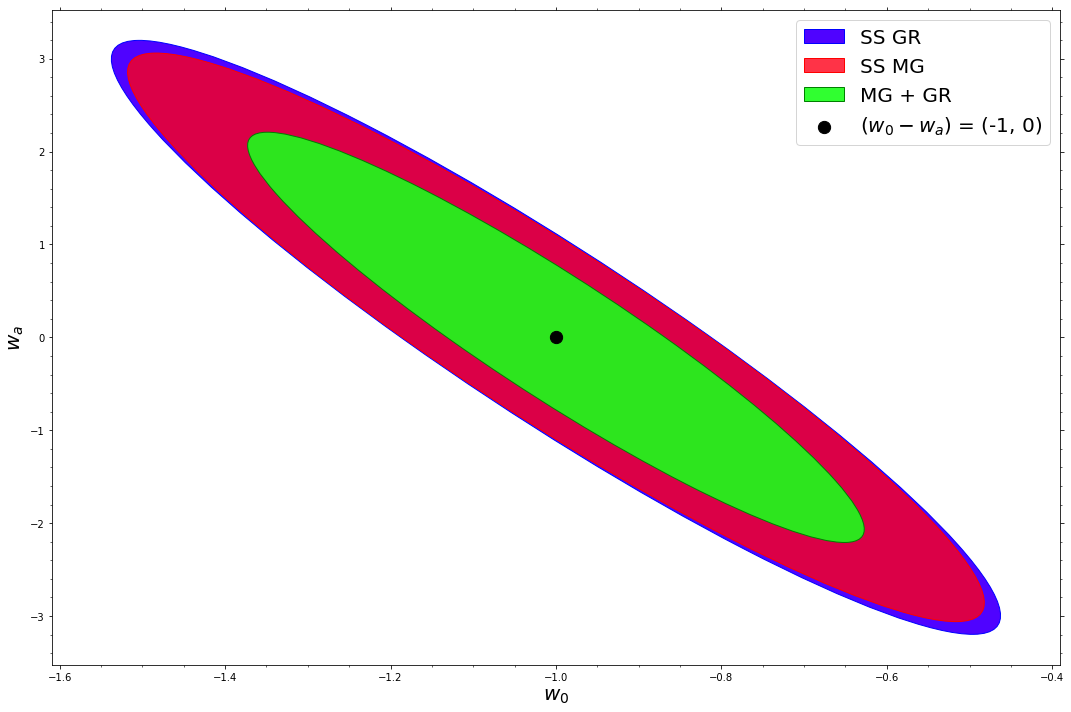

In [59]:
#@title Fisher Plot : joint Constraint
plt.rcParams['figure.figsize'] = [15,10] 
alpha = 1.52
params2 = par(F2[2], F2[3], F2[4]) # GR
params3 = par(F3[2], F3[3], F3[4]) # GW
params4 = par(F4[2], F4[3], F4[4]) # GR + GW

ell   = mpl.patches.Ellipse(xy=[-1, 0],width=params2[1],height=params2[0],angle=-math.degrees(params2[2]), facecolor=(0.3,0,1.,.9),alpha=0.99, edgecolor='b', linewidth=1, label='SS GR')
print('    FOM 1',1/(params2[1]*params2[0]*2.3 ))
ell3 = mpl.patches.Ellipse(xy=[-1, 0],width=params3[1], height=params3[0], angle=-math.degrees(params3[2]), facecolor=(1,0,0.1,0.8), edgecolor='r', label='SS MG')
print('    FOM 2',1/(params3[1]*params3[0]*2.3 ))
ell4 = mpl.patches.Ellipse(xy=[-1, 0],width=params4[1], height=params4[0], angle=-math.degrees(params4[2]), facecolor=(0.1,1,0.1,.9), edgecolor='green', label='MG + GR')
print('    FOM 1+2',1/(params4[1]*params4[0]*2.3 ))

fig, ax = plt.subplots()
ax.add_patch(ell)
ax.add_patch(ell3)
ax.add_patch(ell4)
ax.set_aspect('auto')
ax.set_facecolor('none')
ax.autoscale()  # ''tight
ax.scatter(F2[1], F2[0], c='black', marker='o',s=150, label='($w_0-w_a$) = (-1, 0)',zorder=5)
ax.set_xlabel(r'$w_0$',fontsize=20)
ax.set_ylabel(r'$w_a$',fontsize=20)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')

ax.minorticks_on()
#plt.scatter(F2[1], F2[0], c='black', marker='o',s=150, label='_nolegend_')
plt.legend(loc = 'upper right',prop={'size': 20})
plt.tight_layout()
#plt.savefig('plot3.pdf',bbox_inches='tight')